In [247]:
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point, Polygon
import geopandas as gpd
from shapely.ops import nearest_points
import pyproj

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet

import seaborn as sns

cwd =os.getcwd()

In [248]:
background_data = pd.read_csv('final_data2015.csv').drop(columns='geometry')
geodata = gpd.read_file(cwd+'\scrape_geodata\geodata\dagi_10m_nohist_l1.afstemningsomraade\\afstemningsomraade.shp', driver = 'ESRI Shapefile')
geodata = geodata[['objectid', 'geometry']]
geodata['objectid'] = geodata['objectid'].astype(int)
final_gdf = geodata.merge(background_data, on='objectid', how='right')

final_gdf['left_share_norm']=final_gdf['left_share']/(final_gdf['left_share']+final_gdf['right_share'])
final_gdf['pop_density_log']=np.log(final_gdf['pop_density'])
final_gdf['disindk_log']=np.log(final_gdf['disindk'])
final_gdf['salgspris_log']=np.log(final_gdf['salgspris'])

<AxesSubplot:xlabel='salgspris'>

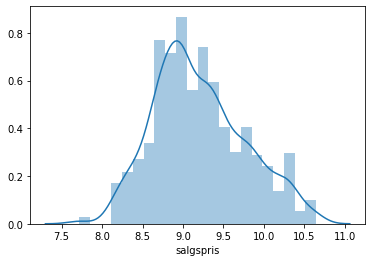

In [249]:
sns.distplot(np.log(final_gdf['salgspris']))

In [250]:
X = final_gdf[['karakter', 'salgspris_log', 'kriminelitet', 'lavindk',
               'langledig', 'skilsmisser', 'andel_indv', 'pop_density_log',
               'disindk_log']]
y = final_gdf['left_share_norm']

# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

In [251]:
pipe_lr = make_pipeline(PolynomialFeatures(include_bias=True), 
                           StandardScaler(),
                            LinearRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_val)
mse(y_pred, y_val)

0.004162525363956261

<AxesSubplot:>

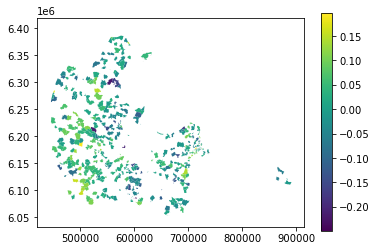

In [252]:
errors = pipe_lr.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
error_gdf.plot(column='left_share_norm_y', legend=True)
# error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_y', ascending=False).dropna()

## Lasso:

In [264]:
perform = []
lambdas = np.logspace(-6, -4, 100)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=True), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1, fit_intercept=True))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))
    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.8f' % optimal.values[0])

Optimal lambda: 4.328761281083062e-05
Validation MSE: 0.00392724


<AxesSubplot:xlabel='x_axis', ylabel='0'>

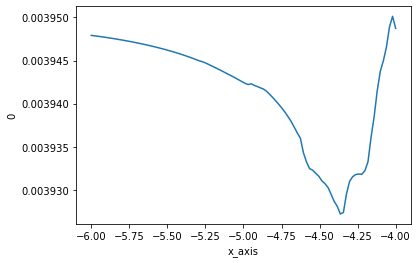

In [265]:
plot_df = pd.DataFrame(hyperparam_perform).reset_index()
plot_df['index'] = np.log10(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
sns.lineplot(data=plot_df, x='x_axis', y=0)

## Ridge:

In [266]:
perform = []
lambdas = np.logspace(-20, 4, 33)
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(include_bias=True), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=1))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_val)
    perform.append(mse(y_pred, y_val))
    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.8f' % optimal.values[0])

C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.24956e-25): result may not be accurate.
  overwrite_a=True).T
C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.51439e-24): result may not be accurate.
  overwrite_a=True).T
C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.97629e-23): result may not be accurate.
  overwrite_a=True).T
C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.11135e-22): result may not be accurate.
  overwrite_a=True).T
C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.24956e-22): result may not be accurate.
  overwrite_a=True).T
C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\lin

Optimal lambda: 0.01
Validation MSE: 0.00378513


In [267]:
errors = pipe_ridge.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
# error_gdf.plot(column='left_share_norm_y', legend=True)

<AxesSubplot:xlabel='x_axis', ylabel='0'>

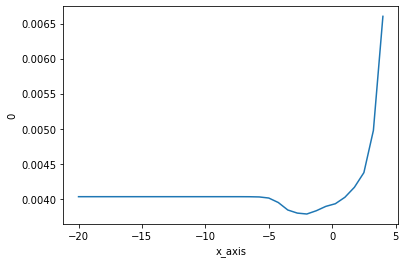

In [268]:
plot_df = pd.DataFrame(hyperparam_perform).reset_index()
plot_df['index'] = np.log10(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
sns.lineplot(data=plot_df, x='x_axis', y=0)

In [63]:
# list(zip(pipe_ridge.steps[2][1].coef_, pipe_ridge.steps[0][1].get_feature_names(X.columns)))

## Lasso - crossvalidation

In [64]:
kfolds = KFold(n_splits=10)
# kfolds = LeaveOneOut()

folds = list(kfolds.split(X_dev, y_dev))
# outer loop: lambdas
mselassoCV = []
lambdas = np.logspace(-6, -1, 33)
for lambda_ in lambdas:    
    # inner loop: folds
    mselassoCV_ = []    
    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.values[train_idx], y_dev.values[train_idx]
        X_val, y_val = X_dev.values[val_idx], y_dev.values[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mselassoCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # store result    
    mselassoCV.append(mselassoCV_) 
    
# convert to DataFrame
lambdalassoCV = pd.DataFrame(mselassoCV, index=lambdas)

0.000018    0.004185
dtype: float64


<AxesSubplot:xlabel='x_axis', ylabel='0'>

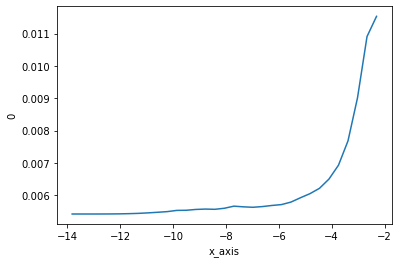

In [65]:
print(lambdalassoCV.mean(axis=1).nsmallest(1))
plot_df = pd.DataFrame(lambdalassoCV).reset_index()
plot_df['index'] = np.log(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
sns.lineplot(data=plot_df, x='x_axis', y=0)

,kommunenavn,opst_kreds,left_share_norm_x,left_share_norm_y
6,København Kommune,Nørrebrokredsen,0.818595,-0.382942
47,København Kommune,Brønshøjkredsen,0.769905,-0.334252
1051,Aarhus Kommune,Aarhus Vestkredsen,0.735110,-0.299457
8,København Kommune,Bispebjergkredsen,0.712846,-0.277193
537,Langeland Kommune,Svendborgkredsen,0.704918,-0.269265
...,...,...,...,...
754,Tønder Kommune,Tønderkredsen,0.207944,0.227709
785,Vejen Kommune,Vejenkredsen,0.200426,0.235226
231,Hørsholm Kommune,Fredensborgkredsen,0.194661,0.240991
639,Billund Kommune,Vejenkredsen,0.188953,0.246699


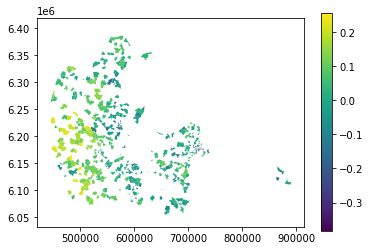

In [66]:
errors = pipe_lassoCV.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
error_gdf.plot(column='left_share_norm_y', legend=True)
error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_x', ascending=False).dropna()

<AxesSubplot:xlabel='left_share_norm_y'>

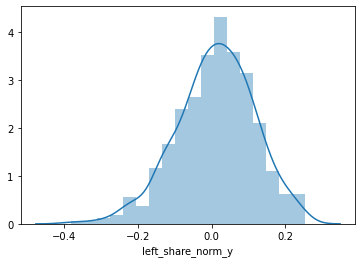

In [67]:
sns.distplot(error_gdf['left_share_norm_y'])

## Ridge - crossvalidation

In [152]:
kfolds = KFold(n_splits=10)
# kfolds = LeaveOneOut()

folds = list(kfolds.split(X_dev, y_dev))
# outer loop: lambdas
mseridgeCV = []
lambdas = np.logspace(-8, 4, 100)
for lambda_ in lambdas:    
    # inner loop: folds
    mseridgeCV_ = []    
    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_ridgeCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Ridge(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.values[train_idx], y_dev.values[train_idx]
        X_val, y_val = X_dev.values[val_idx], y_dev.values[val_idx] 
        pipe_ridgeCV.fit(X_train, y_train)        
        mseridgeCV_.append(mse(pipe_ridgeCV.predict(X_val), y_val))    
        
    # store result    
    mseridgeCV.append(mseridgeCV_) 
    
# convert to DataFrame
lambdaridgeCV = pd.DataFrame(mseridgeCV, index=lambdas)

0.001233    0.004028
dtype: float64


<AxesSubplot:xlabel='x_axis', ylabel='0'>

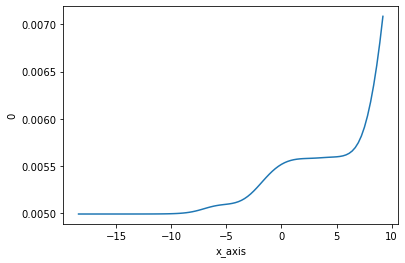

In [153]:
print(lambdaridgeCV.mean(axis=1).nsmallest(1))
plot_df = pd.DataFrame(lambdaridgeCV).reset_index()
plot_df['index'] = np.log(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
sns.lineplot(data=plot_df, x='x_axis', y=0)

,kommunenavn,opst_kreds,left_share_norm_x,left_share_norm_y
6,København Kommune,Nørrebrokredsen,0.818595,-0.217231
47,København Kommune,Brønshøjkredsen,0.769905,-0.187005
1051,Aarhus Kommune,Aarhus Vestkredsen,0.735110,-0.248275
8,København Kommune,Bispebjergkredsen,0.712846,-0.102589
537,Langeland Kommune,Svendborgkredsen,0.704918,-0.293978
...,...,...,...,...
754,Tønder Kommune,Tønderkredsen,0.207944,0.180708
785,Vejen Kommune,Vejenkredsen,0.200426,0.180794
231,Hørsholm Kommune,Fredensborgkredsen,0.194661,0.239574
639,Billund Kommune,Vejenkredsen,0.188953,0.197572


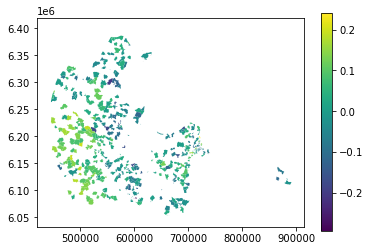

In [70]:
errors = pipe_ridgeCV.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
error_gdf.plot(column='left_share_norm_y', legend=True)
error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_x', ascending=False).dropna()

In [71]:
error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_x', ascending=False).dropna()

,kommunenavn,opst_kreds,left_share_norm_x,left_share_norm_y
6,København Kommune,Nørrebrokredsen,0.818595,-0.217231
47,København Kommune,Brønshøjkredsen,0.769905,-0.187005
1051,Aarhus Kommune,Aarhus Vestkredsen,0.735110,-0.248275
8,København Kommune,Bispebjergkredsen,0.712846,-0.102589
537,Langeland Kommune,Svendborgkredsen,0.704918,-0.293978
...,...,...,...,...
754,Tønder Kommune,Tønderkredsen,0.207944,0.180708
785,Vejen Kommune,Vejenkredsen,0.200426,0.180794
231,Hørsholm Kommune,Fredensborgkredsen,0.194661,0.239574
639,Billund Kommune,Vejenkredsen,0.188953,0.197572


<AxesSubplot:xlabel='left_share_norm_y'>

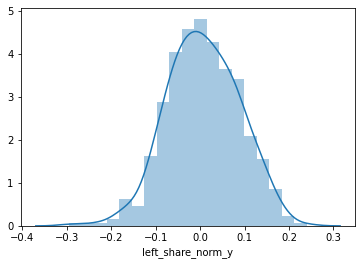

In [72]:
sns.distplot(error_gdf['left_share_norm_y'])

In [73]:
error_gdf['correct_prediction'] = 0
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']>0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])>0.5)] = 1
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']<0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])<0.5)] = 1

# error_gdf['actual prediction'] = ""
# error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']>0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])>0.5)] = 1
# error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']<0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])<0.5)] = 1

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

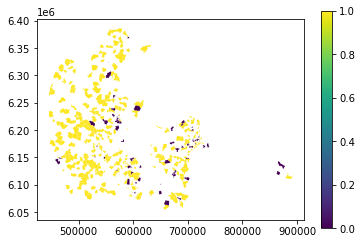

In [74]:
error_gdf.dropna().plot(column='correct_prediction', legend=True)

In [75]:
error_gdf.correct_prediction.sum()/len(error_gdf.dropna())


0.8504464285714286

## Elastic net - crossvalidation:

In [77]:
# compare performance
models = {'LinReg': pipe_lr, 'Lasso': pipe_lasso, 'Lasso CV': pipe_lassoCV,
         'Ridge': pipe_ridge, 'Ridge CV': pipe_ridgeCV,}

LinReg 0.00456
Lasso 0.01128
Lasso CV 0.01121
Ridge 0.01116
Ridge CV 0.00662


In [269]:
pipe_el = make_pipeline(PolynomialFeatures(include_bias=True),StandardScaler(),ElasticNet(random_state=1))
gs = GridSearchCV(estimator=pipe_el,
                  param_grid = {'elasticnet__alpha':np.logspace(-6,2,40)*2,
                              'elasticnet__l1_ratio':np.linspace(0,1,10)},
                  scoring='neg_mean_squared_error',
                  n_jobs=4,
                  iid=False,
                  cv=10)
models['ElasticNetCV'] = gs.fit(X_dev, y_dev)


C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [190]:
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 6))

LinReg 0.004557
Lasso 0.011276
Lasso CV 0.011212
Ridge 0.011161
Ridge CV 0.006622
ElasticNetCV 0.004509


<AxesSubplot:xlabel='left_share_norm_y'>

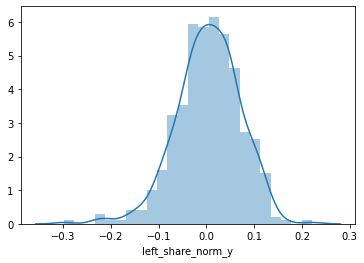

In [158]:
errors = gs.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
# error_gdf.plot(column='left_share_norm_y', legend=True)
# error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_y', ascending=False).dropna()
sns.distplot(error_gdf['left_share_norm_y'])

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Share of voting areas correctly predicted:  0.8883928571428571


<AxesSubplot:>

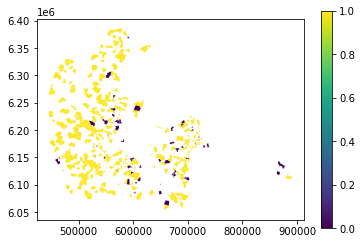

In [161]:
# error_gdf.plot(column='left_share_norm_y', legend=True)
# error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_y', ascending=False).dropna()
error_gdf['correct_prediction'] = 0
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']>0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])>0.5)] = 1
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']<0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])<0.5)] = 1
print('Share of voting areas correctly predicted: ', error_gdf.correct_prediction.sum()/len(error_gdf.dropna()))
error_gdf.dropna().plot(column='correct_prediction', legend=True)

In [103]:
background_data_2019 = pd.read_csv('final_data2019.csv').drop(columns='geometry')
geodata = gpd.read_file(cwd+'\scrape_geodata\geodata\dagi_10m_nohist_l1.afstemningsomraade\\afstemningsomraade.shp', driver = 'ESRI Shapefile')
geodata = geodata[['objectid', 'geometry']]
geodata['objectid'] = geodata['objectid'].astype(int)
final_gdf_2019 = geodata.merge(background_data_2019, on='objectid', how='right')

final_gdf_2019['left_share_norm']=final_gdf_2019['left_share']/(final_gdf_2019['left_share']+final_gdf_2019['right_share'])
final_gdf_2019['pop_density_log']=np.log(final_gdf_2019['pop_density'])
final_gdf_2019['disindk_log']=np.log(final_gdf_2019['disindk'])
final_gdf_2019['salgspris_log']=np.log(final_gdf_2019['salgspris'])

X_2019 = final_gdf_2019[['karakter', 'salgspris_log', 'kriminelitet', 'lavindk',
               'langledig', 'skilsmisser', 'andel_indv', 'pop_density_log',
               'disindk_log']]
y_2019 = final_gdf_2019['left_share_norm']

# splitting into development (2/3) and test data (1/3)
X_dev_2019, X_test_2019, y_dev_2019, y_test_2019 = train_test_split(X_2019, y_2019, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3)
X_train_2019, X_val_2019, y_train_2019, y_val_2019 = train_test_split(X_dev_2019, y_dev_2019, test_size=1/2, random_state=1)

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


0.8824833702882483


<AxesSubplot:>

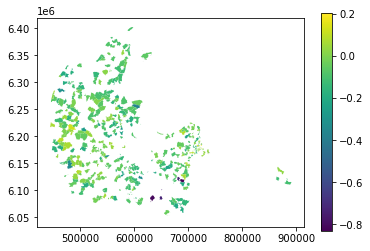

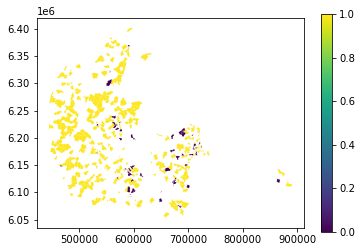

In [104]:
errors = gs.predict(X_test_2019)-y_test_2019
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
error_gdf.plot(column='left_share_norm_y', legend=True)
error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_y', ascending=False).dropna()
error_gdf['correct_prediction'] = 0
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']>0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])>0.5)] = 1
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']<0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])<0.5)] = 1
print(error_gdf.correct_prediction.sum()/len(error_gdf.dropna()))
error_gdf.dropna().plot(column='correct_prediction', legend=True)

In [121]:
gs.predict(X_test_2019)-y_test_2019

992    -0.101390
701     0.031345
776     0.067875
1057   -0.116711
60      0.032269
          ...   
607    -0.029981
1070   -0.156397
596    -0.121450
819    -0.031733
104    -0.097867
Name: left_share_norm, Length: 461, dtype: float64

In [122]:
# gs.predict(X_test_2019)
test_2019 = final_gdf_2019[final_gdf_2019['objectid'].isin(final_gdf.iloc[X_test.index].objectid.values)]
X_test_2019 = test_2019[['karakter', 'salgspris_log', 'kriminelitet', 'lavindk',
               'langledig', 'skilsmisser', 'andel_indv', 'pop_density_log',
               'disindk_log']]
y_test_2019 = test_2019['left_share_norm']
# final_gdf.iloc[X_test.index].objectid.values

In [142]:
# y_test.sort_index().reset_index(drop=True)
# y_test_2019.sort_index().reset_index(drop=True)
X_test.sort_index().reset_index(drop=True)
# X_test_2019.sort_index().reset_index(drop=True)

,karakter,salgspris_log,kriminelitet,lavindk,langledig,skilsmisser,andel_indv,pop_density_log,disindk_log
0,6.0,10.294253,6.4,40.6,1.225,20.8,14.847158,-5.643166,12.254820
1,5.6,10.296365,6.4,40.6,1.225,20.8,14.847158,-4.528661,12.254820
2,7.0,10.238986,6.4,40.6,1.225,20.8,14.847158,-4.080098,12.254820
3,6.5,10.294253,6.4,40.6,1.225,20.8,14.847158,-4.626137,12.254820
4,7.4,10.296365,6.4,40.6,1.225,20.8,14.847158,-5.395370,12.254820
...,...,...,...,...,...,...,...,...,...
453,7.0,9.094200,3.5,20.6,1.175,13.0,5.750086,-9.662368,12.221355
454,7.3,8.862484,3.5,20.6,1.175,13.0,5.750086,-10.437145,12.221355
455,7.9,9.183277,3.5,20.6,1.175,13.0,5.750086,-10.949971,12.221355
456,7.2,9.505581,3.5,20.6,1.175,13.0,5.750086,-8.700080,12.221355


In [143]:
predicted_change = gs.predict(X_test_2019.sort_index().reset_index(drop=True))-gs.predict(X_test.sort_index().reset_index(drop=True))
actual_change = y_test_2019.sort_index().reset_index(drop=True)-y_test.sort_index().reset_index(drop=True)

In [151]:
from scipy.stats import linregress
linregress(predicted_change, actual_change)

LinregressResult(slope=0.046102516557435747, intercept=0.04634454812926201, rvalue=0.11045762083749368, pvalue=0.018045828099497317, stderr=0.0194258863074162)

<AxesSubplot:xlabel='left_share_norm'>

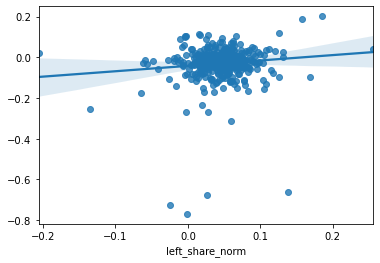

In [150]:
sns.regplot(x=actual_change, y=predicted_change)

In [149]:
import plotly as plt
x = actual_change
y = predicted_change
m, b = np.polyfit(x, y, 1)

plt.plot(x, y)
plt.plot(x, m*x + b)

C:\Users\Gustav\Anaconda3\lib\site-packages\plotly\__init__.py:98: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kind == "scatter":
C:\Users\Gustav\Anaconda3\lib\site-packages\plotly\__init__.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kind == "line":
C:\Users\Gustav\Anaconda3\lib\site-packages\plotly\__init__.py:103: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kind == "area":
C:\Users\Gustav\Anaconda3\lib\site-packages\plotly\__init__.py:105: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kind == "bar":
C:\Users\Gustav\Anaconda3\lib\site-packages\plotly\__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead,

NotImplementedError: kind='[ 5.23869800e-02  1.11390723e-01  7.78055030e-02  6.01159520e-02
  6.05552092e-02  5.01013915e-02  9.01716794e-02  7.12133514e-02
  1.12841944e-01  5.26433542e-02  4.83289420e-02  1.03992333e-01
  6.27847285e-02  4.17629715e-02  5.02867728e-02  3.88666611e-02
  4.01717529e-02 -9.56299440e-03 -4.67221340e-02 -2.30360907e-02
 -4.79760316e-02  6.98480267e-04  4.81399240e-03  5.69755754e-03
  2.06092866e-02 -1.50619748e-01 -1.38295208e-01 -1.29171777e-01
  1.02938745e-01  1.03759580e-01  1.08865681e-01  9.81642631e-02
  8.97635641e-02  4.06358319e-02  5.54519304e-02  4.81560673e-02
  5.20113727e-02 -1.52634842e-01 -1.16442833e-01 -9.99484570e-02
  7.54307947e-02  6.32917474e-02  4.74728303e-02 -2.08763543e-02
 -1.95213440e-02 -6.10618919e-03  2.82815624e-02  3.79949788e-02
  3.92878191e-02  2.54460402e-02  6.92412207e-02 -3.13203457e-02
  1.30263373e-02 -2.01203299e-02 -1.06110512e-02  2.43955289e-02
  2.25580377e-02 -2.31360043e-02  1.57181027e-03  1.00073918e-03
 -4.43280059e-03 -5.66379896e-03 -4.40540156e-03 -2.36888451e-02
  8.56979766e-03 -2.14200726e-02  4.06499242e-02  8.13755177e-03
 -2.35767045e-03 -1.29131286e-02  6.88485093e-03  1.43073803e-02
  1.38267740e-02 -8.01932126e-02  3.22013686e-02 -9.88125403e-02
 -2.42718067e-02 -7.59115386e-02  1.67614027e-02 -6.15900917e-03
  1.28531669e-02  5.48132470e-03 -4.80533423e-03 -5.41494227e-02
 -3.33755286e-02 -7.01630535e-02  2.48720174e-02  2.21649964e-02
  1.36225137e-02 -2.23334486e-02 -1.18290755e-02 -4.03007380e-02
  2.17522269e-04 -4.25654316e-02  2.06254136e-02 -2.09306185e-02
 -1.00202856e-03 -4.24642887e-02 -3.77953006e-02 -2.98221493e-02
 -1.05423619e-02 -3.91473251e-02 -4.18139894e-02 -2.72164910e-02
 -2.32455437e-02 -5.80109394e-02 -5.88689244e-02 -5.38941103e-02
 -1.00024619e-01 -1.08363625e-01 -1.11135946e-01 -1.01812613e-01
 -1.10049630e-01 -8.57619924e-02 -1.18664090e-01 -9.28573277e-02
 -1.49386479e-02  2.29057013e-02  2.37525138e-02  3.88631944e-02
 -2.92346398e-02 -1.56872364e-02 -3.17876771e-02  3.00383097e-02
 -2.25002356e-02 -6.62650514e-01 -7.26402551e-01 -6.75319814e-01
 -7.69613569e-01 -1.45317722e-02 -3.42654973e-03 -1.32761613e-02
 -2.87402582e-02  8.36748309e-03 -3.99622253e-02  5.18431260e-03
  1.11388206e-02  4.96533241e-02  2.15748307e-02 -3.03024886e-02
 -3.07505455e-02 -1.70070291e-02 -1.00394526e-01 -1.86243380e-02
 -1.44104910e-02 -3.26017450e-02  7.25112129e-02 -1.22401090e-01
 -1.69975211e-01 -1.14583962e-01 -1.65867328e-01 -2.54279891e-01
  1.85766890e-01 -1.37681285e-01 -5.54486005e-02 -3.65491473e-02
 -4.51285882e-02 -6.19241312e-02 -1.56160273e-02 -5.15272751e-02
 -4.85559364e-02 -1.49457618e-02 -2.40039267e-02 -3.10822032e-02
 -6.26123731e-03 -2.94777855e-02 -4.39810041e-02 -2.62964595e-02
 -3.27669698e-02 -3.75821122e-02 -8.22261703e-02 -3.79503471e-02
 -5.47510237e-02  1.63364196e-02  9.23547020e-03 -7.00862043e-02
  1.86273866e-03 -1.53145375e-02 -3.97912182e-02 -5.46906173e-02
 -2.84102316e-02  3.06453843e-03 -1.23343764e-03  2.87897545e-03
 -1.14057966e-02 -2.11995277e-02 -3.37831781e-02 -3.18043842e-02
 -3.28104610e-02 -1.71192364e-01 -1.05562096e-01 -8.07386810e-02
 -1.32410538e-01 -1.21183355e-01 -2.33392766e-01 -2.69895353e-01
 -2.68598297e-01 -3.10533505e-01 -4.34596175e-02  2.01270477e-01
 -3.57352453e-02 -2.78932794e-02 -1.48940234e-02  1.18570402e-01
 -5.91956957e-02 -5.43685754e-03 -1.84421479e-02 -4.87346993e-03
 -2.93825642e-02  4.90126375e-03 -2.74749983e-02 -2.23654744e-02
  1.39230635e-02 -2.02321357e-02  4.35214777e-02 -7.98536808e-02
 -5.47470705e-02 -5.77635940e-02  3.62528327e-02  4.14600833e-02
 -1.09335700e-02 -4.03873624e-02 -7.78773138e-02 -3.01915754e-02
 -4.31222774e-02 -3.13744350e-02 -2.83300616e-02 -2.57071454e-02
 -3.83026242e-02 -6.79008319e-02 -6.50559120e-03 -1.33621479e-02
 -2.09825453e-02  3.56854129e-02  2.86241611e-02 -9.10750782e-03
  1.36140841e-03 -8.18938384e-03 -7.98389972e-03 -7.42528738e-03
  5.73220936e-03 -1.22059937e-02 -3.26944851e-02 -3.41113380e-02
 -2.25377101e-02 -3.53615765e-02 -1.47877181e-02 -1.60698518e-02
 -3.06158433e-02 -2.76446144e-02 -5.22588590e-02 -5.50143055e-02
 -3.34220524e-02 -6.42341025e-02 -4.54074559e-02 -3.00891288e-02
 -5.66894636e-02 -1.73807143e-01 -1.18416995e-01 -1.18505220e-01
 -1.10443750e-01 -1.12616638e-01 -9.72538258e-02 -1.07036602e-01
  6.96691389e-03  9.01452710e-03  1.49399077e-02  1.83352261e-02
 -2.24457982e-03  3.21624243e-02  8.50941528e-03  2.11677615e-02
 -2.25249704e-02 -1.81716782e-02 -2.84832013e-02 -1.48845113e-02
 -1.75424651e-02 -2.78563054e-02 -2.05447740e-02 -2.09746391e-02
 -2.99526414e-02 -2.80377903e-02 -2.13863034e-02 -3.18068171e-02
 -3.78754001e-02 -4.89329298e-02 -1.14771718e-02 -3.69378032e-02
 -3.98042555e-02 -3.68424328e-02 -4.80995795e-02 -3.50451999e-02
 -6.32979903e-02 -6.13388480e-02 -5.89765569e-02 -5.14810328e-02
 -1.77460909e-02 -1.73164430e-02 -1.62734283e-02 -1.15784282e-02
 -1.86565241e-02  1.85671440e-02  8.96693318e-03  9.98679369e-03
  1.20838254e-02  6.28502235e-03  2.12544802e-02  1.68738786e-02
 -4.51989579e-02 -3.24067433e-02 -2.25951277e-02 -5.04447502e-02
 -7.08645030e-02 -4.31031834e-02 -2.19056802e-02 -1.18744551e-01
 -1.28135942e-01 -6.96922022e-02 -4.73814518e-02 -2.80494410e-02
 -2.51807858e-02 -3.73064453e-02 -1.73517758e-02 -5.49676173e-02
 -2.34749968e-02 -1.48989461e-02 -1.42310355e-01 -1.82596054e-02
 -1.14494883e-02  4.02299392e-02  2.30576630e-02  2.47337421e-02
  8.74528478e-03 -1.54578703e-01  1.95361733e-02 -2.34779152e-02
 -3.16491468e-02 -2.46247853e-02 -2.05390659e-02 -2.06869600e-02
 -1.37695041e-02 -2.81694325e-03 -2.87294069e-03 -5.81943296e-03
 -1.57221301e-02 -3.29629329e-03 -2.21627797e-02  3.38728325e-02
 -2.58163505e-02 -8.47594624e-03 -1.82845399e-02  7.71230263e-02
  3.06168958e-02  1.95055131e-03  6.63571422e-04 -1.43247016e-02
  9.44769901e-02 -1.94984991e-02 -1.44237276e-04  3.31942696e-03
  7.18622538e-03 -1.46096626e-02 -2.40590881e-02 -8.77514293e-02
 -8.01138247e-02 -7.58088295e-02 -7.48125552e-02 -8.43934786e-02
 -6.94330975e-02 -4.08602973e-02 -5.87173350e-02 -9.86732633e-02
 -7.96349384e-02 -9.55463595e-02 -3.51978829e-03 -2.96824607e-02
 -3.37789674e-02 -5.75560543e-02 -1.68725572e-02 -4.92390836e-02
  9.28559732e-03  1.74757142e-02  1.16603533e-02 -6.13333282e-03
 -1.79907504e-02 -1.86505021e-02 -1.37783818e-02 -5.40540554e-03
 -7.50032679e-03  4.46632189e-03 -3.67250616e-02 -1.95022853e-02
  2.36065715e-02 -4.65602821e-02 -4.11219295e-02 -4.58251220e-02
 -4.01198439e-02 -3.93544568e-02 -4.60289403e-02 -3.00461075e-02
 -5.44699827e-02 -2.22339974e-02 -2.14727967e-02 -2.34269985e-02
 -2.14576200e-02 -2.60447115e-02 -1.89642564e-02 -2.78314255e-02
 -2.82961995e-02 -4.52935453e-02 -1.21842954e-02 -3.34329456e-02
 -2.94507018e-02 -7.51267105e-03 -1.28652357e-02 -2.68936164e-02
 -3.29034801e-02 -5.69652767e-02 -8.35328956e-02 -1.93337046e-02
  5.08046555e-02 -1.05024202e-01 -4.14178368e-02 -3.48448284e-02
 -2.83013402e-02 -3.09505764e-02 -3.40216001e-02 -1.96040682e-02
 -2.83706801e-02 -1.48777767e-01 -1.68069384e-02 -8.74359454e-02
 -9.81661258e-02 -7.50248782e-02 -8.65937238e-03  9.88542649e-03
  7.59612240e-04  1.90961305e-02  4.52943720e-02  9.59251309e-03
 -4.72538471e-02 -3.22206770e-02 -4.98749054e-02 -2.43757946e-02
  3.83924725e-03 -3.62372655e-02 -3.00365188e-02 -5.98387598e-02
  3.23802611e-03  4.35688494e-03 -2.83167949e-02 -1.69133528e-02
 -2.13597732e-02 -4.19013912e-02 -6.12017472e-02 -7.05639889e-02
 -4.19740492e-02 -1.79104103e-02]' not yet supported for plotting.backend='plotly'